In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

#fetching wheat data from yahoo finance
data = yf.Ticker('ZW=F')
data = yf.download('ZW=F', period = 'max')

# Resetting the index to turn the date index into a column
data.reset_index(inplace=True)

data

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-07-17,248.00,248.00,243.75,244.00,244.00,7233
1,2000-07-18,244.25,247.50,241.00,241.25,241.25,6523
2,2000-07-19,241.25,246.00,239.00,245.00,245.00,7136
3,2000-07-20,244.00,247.50,244.00,247.00,247.00,3792
4,2000-07-21,247.00,248.50,246.50,247.25,247.25,4380
...,...,...,...,...,...,...,...
5907,2024-03-18,531.25,544.00,527.00,542.75,542.75,57975
5908,2024-03-19,542.75,553.75,539.00,552.50,552.50,52072
5909,2024-03-20,551.75,553.00,537.00,545.00,545.00,52836
5910,2024-03-21,546.00,552.50,540.25,546.75,546.75,52836


In [3]:
# trim dataset to relevent columns (we only need date and close to forecast prices)
data = data[['Date', 'Close']]
data

,Date,Close
0,2000-07-17,244.00
1,2000-07-18,241.25
2,2000-07-19,245.00
3,2000-07-20,247.00
4,2000-07-21,247.25
...,...,...
5907,2024-03-18,542.75
5908,2024-03-19,552.50
5909,2024-03-20,545.00
5910,2024-03-21,546.75


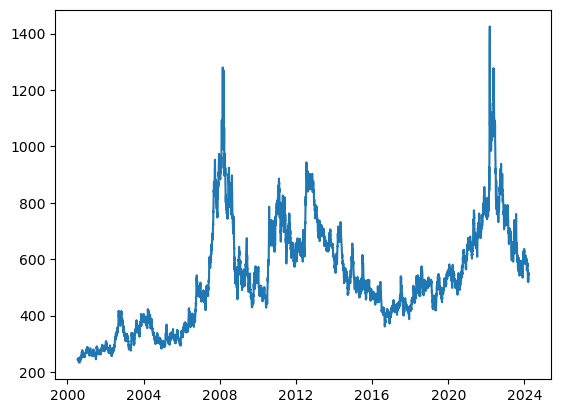

In [4]:
#simple transformations
data.loc[:, 'Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [6]:
#takes df from above and creates a lookback window of a week (lookback =7) 
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    df.set_index('Date', inplace=True)
    
    #shifts dataframe for each lookback window
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2000-07-26,244.25,245.50,245.50,247.25,247.00,245.00,241.25,244.00
2000-07-27,245.75,244.25,245.50,245.50,247.25,247.00,245.00,241.25
2000-07-28,248.50,245.75,244.25,245.50,245.50,247.25,247.00,245.00
2000-07-31,246.00,248.50,245.75,244.25,245.50,245.50,247.25,247.00
2000-08-01,245.00,246.00,248.50,245.75,244.25,245.50,245.50,247.25
...,...,...,...,...,...,...,...,...
2024-03-18,542.75,528.50,519.50,532.25,535.50,537.50,526.75,520.75
2024-03-19,552.50,542.75,528.50,519.50,532.25,535.50,537.50,526.75
2024-03-20,545.00,552.50,542.75,528.50,519.50,532.25,535.50,537.50


In [7]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[244.25, 245.5 , 245.5 , ..., 245.  , 241.25, 244.  ],
       [245.75, 244.25, 245.5 , ..., 247.  , 245.  , 241.25],
       [248.5 , 245.75, 244.25, ..., 247.25, 247.  , 245.  ],
       ...,
       [545.  , 552.5 , 542.75, ..., 532.25, 535.5 , 537.5 ],
       [546.75, 545.  , 552.5 , ..., 519.5 , 532.25, 535.5 ],
       [544.75, 546.75, 545.  , ..., 528.5 , 519.5 , 532.25]])

In [8]:
shifted_df_as_np.shape

(5905, 8)

In [9]:
#runs scaler on data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.9819593 , -0.97986155, -0.97986155, ..., -0.98070065,
        -0.98699392, -0.98237885],
       [-0.979442  , -0.9819593 , -0.97986155, ..., -0.97734424,
        -0.98070065, -0.98699392],
       [-0.97482694, -0.979442  , -0.9819593 , ..., -0.97692469,
        -0.97734424, -0.98070065],
       ...,
       [-0.47723935, -0.46465282, -0.48101531, ..., -0.49863646,
        -0.49318229, -0.48982589],
       [-0.4743025 , -0.47723935, -0.46465282, ..., -0.52003356,
        -0.49863646, -0.49318229],
       [-0.4776589 , -0.4743025 , -0.47723935, ..., -0.50492973,
        -0.52003356, -0.49863646]])

In [10]:
#changes df into x and y
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((5905, 7), (5905,))

In [11]:
X = dc(np.flip(X, axis=1))
X

array([[-0.98237885, -0.98699392, -0.98070065, ..., -0.97692469,
        -0.97986155, -0.97986155],
       [-0.98699392, -0.98070065, -0.97734424, ..., -0.97986155,
        -0.97986155, -0.9819593 ],
       [-0.98070065, -0.97734424, -0.97692469, ..., -0.97986155,
        -0.9819593 , -0.979442  ],
       ...,
       [-0.48982589, -0.49318229, -0.49863646, ..., -0.50492973,
        -0.48101531, -0.46465282],
       [-0.49318229, -0.49863646, -0.52003356, ..., -0.48101531,
        -0.46465282, -0.47723935],
       [-0.49863646, -0.52003356, -0.50492973, ..., -0.46465282,
        -0.47723935, -0.4743025 ]])

In [12]:
#use first 95% as train and last 5% as test
split_index = int(len(X) * 0.95)

split_index

5609

In [13]:
# splitting into train and test
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5609, 7), (296, 7), (5609,), (296,))

In [14]:
#PyTorch requires an extra dimension at end
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5609, 7, 1), (296, 7, 1), (5609, 1), (296, 1))

In [15]:
#wrapping in tensors for PyTorch
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([5609, 7, 1]),
 torch.Size([296, 7, 1]),
 torch.Size([5609, 1]),
 torch.Size([296, 1]))

In [16]:
#need datasets object for PyTorch
#needs to be custom class
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [17]:
train_dataset

In [18]:
# wrap datasets in dataloaders to get batches
# used for iteration
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
#gives predicted outputs of arrays
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [20]:
#takes in number of features, dimensions and number of stacked layers (more layers = more complexity in model)
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        
        #initally use 1 layer to prevent overfitting in training data
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        #maps hidden layer to 1. Needed to predict final closing value
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        #initialise LSTM with default h0 and c0
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        #output is gotten from passing varibles in fully connected layer
        out = self.fc(out[:, -1, :])
        return out

#initial model has 1 input size, 4 hidden sizes and 1 stacked layer
#model = LSTM(1, 4, 1) MSE: 2.41
#model = LSTM(1, 8, 2) MSE: 2.19
#model = LSTM(1, 16, 4) MSE: 3.10
#model = LSTM(1, 12, 4) MSE: 2.62
#model = LSTM(1, 8, 4) MSE: 2.67
#model = LSTM(1, 8, 8) MSE: 4.007
model = LSTM(1, 4, 2) #MSE: 2.019
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, num_layers=2, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [21]:
#sets model to training mode
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        #puts x and y batch onto device we're using 
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        #comparing model's output to ground truth
        #loss is a tensor with a single value
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        #zero out gradients 
        optimizer.zero_grad()
        #backwards pass 
        loss.backward()
        optimizer.step()

        #every 100 batches get avg loss across batches and print
        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [22]:
#sets model to validate mode
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        #don't need to calcualte gradient as there's no model updates
        with torch.no_grad():
            output = model(x_batch)
            #compare output to ground truth
            loss = loss_function(output, y_batch)
            running_loss += loss.item()
    #average loss value across all batches
    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [23]:
learning_rate = 0.001
#10 epochs is all that is necessary as any more will cause overfitting
num_epochs = 10
#trying to minimise mean squared error
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.258
Batch 200, Loss: 0.085
Batch 300, Loss: 0.029

Val Loss: 0.005
***************************************************

Epoch: 2
Batch 100, Loss: 0.005
Batch 200, Loss: 0.004
Batch 300, Loss: 0.004

Val Loss: 0.003
***************************************************

Epoch: 3
Batch 100, Loss: 0.003
Batch 200, Loss: 0.002
Batch 300, Loss: 0.002

Val Loss: 0.002
***************************************************

Epoch: 4
Batch 100, Loss: 0.002
Batch 200, Loss: 0.002
Batch 300, Loss: 0.001

Val Loss: 0.002
***************************************************

Epoch: 5
Batch 100, Loss: 0.002
Batch 200, Loss: 0.002
Batch 300, Loss: 0.001

Val Loss: 0.002
***************************************************

Epoch: 6
Batch 100, Loss: 0.002
Batch 200, Loss: 0.001
Batch 300, Loss: 0.002

Val Loss: 0.002
***************************************************

Epoch: 7
Batch 100, Loss: 0.001
Batch 200, Loss: 0.002
Batch 300, Loss: 0.001

Val Loss: 0.001
*****************

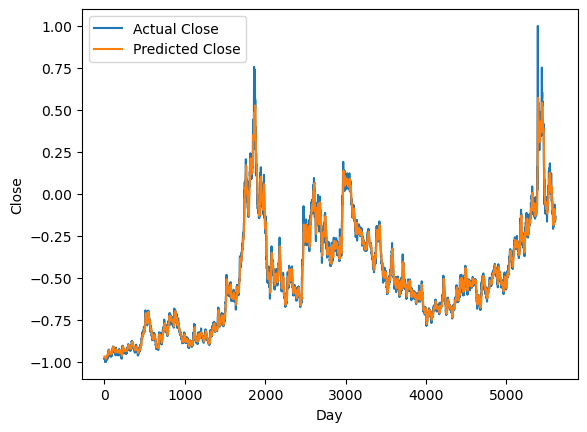

In [24]:
#no gradients for predictions
with torch.no_grad():
    #makes sure it on the device and is put to the CPU (numpy doesn't use GPU)
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [25]:
#above data still includes scalar begins at -1
#do opposite of earlier transform
train_predictions = predicted.flatten()

#lookback+1 is the length of the whole dataset
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

#return in right scale
train_predictions = dc(dummies[:, 0])
train_predictions

array([252.61080101, 252.71401317, 252.99282098, ..., 736.36485866,
       736.71082895, 738.63327092])

In [26]:
#first column is no y_train.flatter()
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([244.25001203, 245.74999802, 248.50000192, ..., 743.74999791,
       751.74999716, 742.49999775])

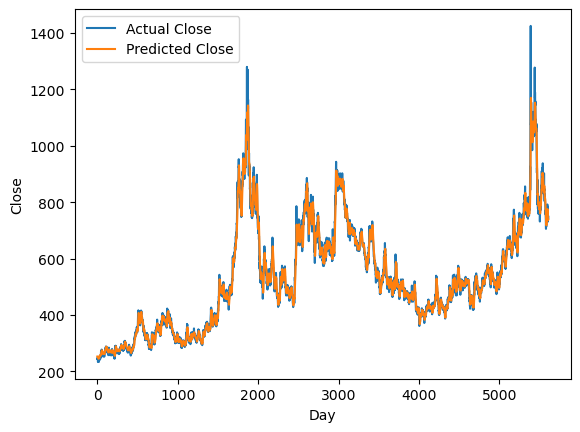

In [27]:
#same graph as earlier with different y_train and predictions
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [28]:
#convert to vector of predictions 
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([739.54293021, 738.60560324, 738.37914737, 734.42341514,
       732.0391467 , 731.71160968, 734.01791849, 737.18629393,
       740.7526897 , 745.00134771, 749.31150326, 752.31207902,
       753.66374635, 752.85136789, 751.43477563, 752.28950801,
       752.52248124, 757.55899771, 764.79676839, 771.1044309 ,
       773.28366018, 772.440382  , 769.99186346, 765.16078128,
       756.88510859, 749.18941385, 738.33247814, 726.33873468,
       714.725555  , 705.80590732, 700.53571173, 696.92301965,
       692.21917683, 689.18997443, 685.33445319, 678.29434304,
       672.80589599, 669.51282065, 670.23827146, 675.52356174,
       681.07867404, 688.27216401, 693.82582012, 694.13392938,
       689.12020145, 682.01458034, 678.95257808, 679.95831063,
       682.54223743, 686.97352343, 689.89106063, 691.91753165,
       692.90721056, 692.08930922, 689.41298516, 685.51763169,
       682.0471316 , 679.03614938, 677.29088356, 674.32024857,
       673.9158707 , 677.07089178, 681.53535057, 683.12

In [29]:
#make ground truth proper scale
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([734.4999985 , 741.50000117, 720.00000374, 734.4999985 ,
       741.24999759, 752.49999903, 749.99999871, 752.49999903,
       761.25000015, 759.75000084, 761.000001  , 756.7499978 ,
       750.25000229, 749.750004  , 764.75000149, 757.25000052,
       785.99999977, 792.00000143, 785.99999977, 769.2499994 ,
       765.00000063, 765.49999892, 750.499997  , 736.50000053,
       738.24999898, 708.25000401, 695.99999711, 691.50000364,
       697.00000257, 701.25000134, 695.75000241, 682.49999894,
       684.74999567, 674.49999969, 653.50000055, 666.74999514,
       672.25000295, 686.500003  , 702.7499962 , 698.99999572,
       710.50000075, 700.75000305, 683.25000081, 663.50000183,
       661.99999809, 688.49999615, 697.99999915, 699.7499976 ,
       704.74999824, 692.24999663, 692.24999663, 693.49999679,
       691.50000364, 682.00000065, 675.49999626, 678.50000375,
       673.99999252, 679.50000033, 666.99999873, 682.49999894,
       696.50000428, 697.99999915, 681.74999706, 667.74

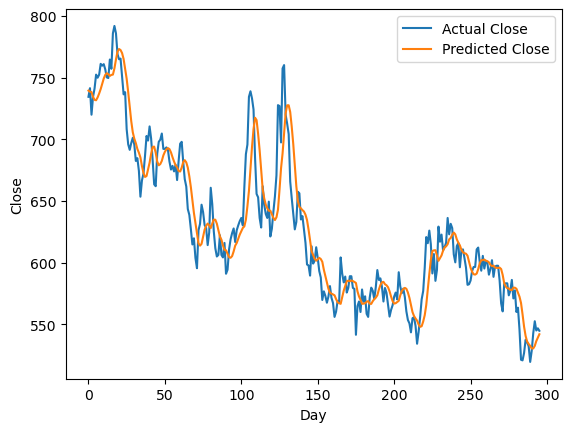

In [30]:
#revised graph with more accurate axises 
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [31]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# For each model, replace `actuals` and `predictions` with the corresponding variables
actuals = new_y_test
predictions = test_predictions

# Calculate the RMSE
rmse = sqrt(mean_squared_error(actuals, predictions))
print("Root Mean Square Error (RMSE):", rmse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actuals, predictions)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
print("Mean Absolute Percentage Error (MAPE):", mape)


Root Mean Square Error (RMSE): 21.882364794317546
Mean Absolute Error (MAE): 15.920611798190638
Mean Absolute Percentage Error (MAPE): 2.5030184014831853


In [32]:
#comparing the RMSE, MAE and MAPE for Training vs Validation data to check for overfitting
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import torch

def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    predictions, actuals = [], []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.view(-1).tolist())
            actuals.extend(targets.view(-1).tolist())

    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    mape = np.mean(np.abs((np.array(actuals) - np.array(predictions)) / np.array(actuals))) * 100
    
    return rmse, mae, mape

# Assuming 'train_loader' and 'test_loader' are already defined
# Evaluate the model on training data
train_rmse, train_mae, train_mape = evaluate_model(model, train_loader)
print(f'Training - RMSE: {train_rmse:.3f}, MAE: {train_mae:.3f}, MAPE: {train_mape:.3f}%')

# Evaluate the model on test (validation) data
val_rmse, val_mae, val_mape = evaluate_model(model, test_loader)  # Use test_loader as validation loader
print(f'Validation - RMSE: {val_rmse:.3f}, MAE: {val_mae:.3f}, MAPE: {val_mape:.3f}%')


Training - RMSE: 0.035, MAE: 0.023, MAPE: 20.375%
Validation - RMSE: 0.037, MAE: 0.027, MAPE: 10.324%


In [33]:
# Correcting the approach to reshape and inverse transform the prediction
latest_input = shifted_df_as_np[-1, 1:].reshape(1, lookback, 1)  # Reshape for LSTM: [1, lookback, 1]

# Convert to PyTorch tensor
latest_input_tensor = torch.tensor(latest_input).float().to(device)

# Make the prediction
model.eval()  # Ensure the model is in evaluation mode
with torch.no_grad():
    prediction_scaled = model(latest_input_tensor).cpu().numpy()

# Prepare the data for inverse transformation correctly
prediction_scaled_expanded = np.expand_dims(prediction_scaled.flatten(), axis=0)
dummy_features = np.zeros((1, lookback))
combined_prediction = np.concatenate((prediction_scaled_expanded, dummy_features), axis=1)

# Inverse transform the prediction to get it back into the original scale
prediction = scaler.inverse_transform(combined_prediction)[0, 0]

print(f'Predicted wheat price for tomorrow: {prediction}')


Predicted wheat price for tomorrow: 537.0495636835694
